# Predicting Flight Delay

Problem Set-up:
We define a delayed flight to be one that is delayed by >= 15 minutes. 
The prediction problem is to train a model that can classify flights, to predict if they will or will not be delayed.

Use case:
- The idea is that this model would be useful to choosing airlines, flightpaths, airports, at the time of booking, relatively in advance of the scheduled departure (days, weeks, months ahead of time). Therefore, the prediction problem will focus on features that can be known in advance, rather than predicting using day-off features like weather and previous flights from that day. 

Notes:
- We restrict the analysis to relatively large airport, those with more than 20 (domestic) flights a day

# This notebook: more features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

# Create separate models to predict for each airport 

Motivation:
The weights that should eb put on features (e.g. airlines) may differ depending on the airport (see e.g. NB 4B) since different airports can have different environments (e.g. San Diego and Chicago winters are very different; American Airlines is better in Tuscon than in Anchorage.

In [2]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [3]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [4]:
airlines_df, airports_df, flights_df = flio.load_data()

In [5]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [6]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [7]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [8]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

In [73]:
len(flights_df)

5249526

# Remove cancelled flights

In [9]:
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


# Make train and val set

In [10]:
N_flights = 1000000
N_train = int(N_flights*.7)
np.random.seed(0)
flight_take_idx = np.random.permutation(flights_df.index)[:N_flights]
df_trainval = flights_df.loc[flight_take_idx]

In [11]:
df_trainval.head(20)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
3783504,8,23,7,WN,285,N7738A,MCI,DEN,1410,1408.0,...,1414.0,105.0,95.0,83.0,533,1437.0,6.0,1455,1443.0,-12.0
5412589,12,5,6,AS,335,N520AS,SJC,SEA,1550,1534.0,...,1554.0,120.0,135.0,105.0,697,1739.0,10.0,1750,1749.0,-1.0
5347613,12,1,2,UA,1750,N76254,SAN,IAH,1314,1354.0,...,1406.0,188.0,168.0,148.0,1303,1834.0,8.0,1822,1842.0,20.0
2383329,5,31,7,WN,396,N8318F,AUS,DEN,1935,2039.0,...,2051.0,140.0,128.0,109.0,775,2140.0,7.0,2055,2147.0,52.0
2817074,6,26,5,EV,4899,N133EV,ATL,MYR,1454,1509.0,...,1533.0,85.0,77.0,49.0,317,1622.0,4.0,1619,1626.0,7.0
5428910,12,6,7,OO,5236,N756SK,ORD,OKC,1913,1925.0,...,1949.0,133.0,121.0,91.0,693,2120.0,6.0,2126,2126.0,0.0
4073892,9,10,4,HA,516,N484HA,HNL,OGG,2150,2144.0,...,2155.0,38.0,41.0,23.0,100,2218.0,7.0,2228,2225.0,-3.0
2296450,5,26,2,EV,6176,N12996,EWR,GSO,1306,1318.0,...,1330.0,99.0,85.0,68.0,445,1438.0,5.0,1445,1443.0,-2.0
1182922,3,18,3,WN,1969,N932WN,TPA,MDW,1330,1330.0,...,1344.0,160.0,159.0,141.0,997,1505.0,4.0,1510,1509.0,-1.0
5228455,11,23,1,WN,2375,N8323C,IND,TPA,1545,1546.0,...,1555.0,135.0,119.0,105.0,837,1740.0,5.0,1800,1745.0,-15.0


# Randomly take subset of data

# Compute features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

### 0. Original feat

In [12]:
original_feat = {'f_distance':df_trainval['DISTANCE'].values}

In [13]:
y_delay = df_trainval['DEPARTURE_DELAY'].values
y_delay01 = y_delay > 15

### 1. Day of week

In [14]:
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [15]:
daysfeat_dict = make_onehot_feat_dict(df_trainval, 'DAY_OF_WEEK', 'day')

### 2. Month

In [16]:
monthsfeat_dict = make_onehot_feat_dict(df_trainval, 'MONTH', 'month') 

### 3. Departing airport

In [17]:
dapfeat_dict = make_onehot_feat_dict(df_trainval, 'ORIGIN_AIRPORT', 'dap') 

### 4. Airline

In [18]:
alfeat_dict = make_onehot_feat_dict(df_trainval, 'AIRLINE', 'al') 

### 5. Departure hour

In [19]:
# Add departure hour as a feature
df_trainval['HOUR_DEPARTURE'] = np.floor(df_trainval['SCHEDULED_DEPARTURE'].values/100).astype(int)
df_trainval['HOUR_ARRIVAL'] = np.floor(df_trainval['SCHEDULED_ARRIVAL'].values/100).astype(int)
hrfeat_dict = make_onehot_feat_dict(df_trainval, 'HOUR_DEPARTURE', 'hr')

# Save new feature matrix

In [20]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, dapfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [21]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Split data by airport

In [64]:
# zscore all features
from scipy.stats import zscore
df_feat_zscore = df_feat.apply(zscore)

In [65]:
airport_keys = np.array(df_feat.keys()[df_feat.columns.str.startswith('f_dap')])
feat_keys = np.array(df_feat.keys()[~df_feat.columns.str.startswith('f_dap')])
ap_keys = [s[-3:] for s in airport_keys]

N_airports = len(airport_keys)
airport_dfs = {}
airport_y = {}
for k in airport_keys:
    airport_dfs[k[-3:]] = df_feat_zscore[feat_keys][df_feat[k].values]
    airport_y[k[-3:]] = y_delay01[df_feat[k].values]
    
Nflights_by_airport = {}
for k in ap_keys:
    Nflights_by_airport[k] = len(airport_y[k])

# Train model for each airport

In [66]:
all_models = {}
all_X_train = {}
all_X_val = {}
all_y_train = {}
all_y_val = {}
aps_trained_idx = []
all_Nflights = {}
min_Nflights_train = 1000
for i, ap in enumerate(ap_keys):
    
    # Compute number of training examples
    N_train = int(Nflights_by_airport[ap]*.7)
    
    if N_train >= 1000:
        print(ap, N_train)
        aps_trained_idx.append(i)
        all_Nflights[ap] = Nflights_by_airport[ap]
        # Declare DFs
        all_X_train[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[:N_train]].values
        all_X_val[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[N_train:]].values

        # Determine labels
        all_y_train[ap] = airport_y[ap][:N_train]
        all_y_val[ap] = airport_y[ap][N_train:]

        C = 100
        all_models[ap] = LogisticRegression(C=C)
        #model = LogisticRegression(C=C,fit_intercept=False)
        #model = LogisticRegression(C=C,class_weight='balanced')
        all_models[ap].fit(all_X_train[ap], all_y_train[ap])

ABQ 2782
ALB 1074
ANC 2284
ATL 50049
AUS 6078
BDL 2676
BHM 1762
BNA 6687
BOI 1673
BOS 15496
BUF 2366
BUR 2699
BWI 12289
CHS 1685
CLE 4948
CLT 14466
CMH 3470
CVG 2893
DAL 8664
DAY 1243
DCA 10317
DEN 28238
DFW 34020
DSM 1173
DTW 15688
ELP 1738
EWR 14349
FAT 1031
FLL 10532
GEG 1428
GRR 1488
HNL 6256
HOU 7557
HPN 1058
IAD 4955
IAH 20940
ICT 1124
IND 3644
JAN 1042
JAX 2559
JFK 13244
KOA 1568
LAS 19266
LAX 28103
LGA 13678
LGB 1238
LIH 1484
LIT 1467
MAF 1057
MCI 5536
MCO 15783
MDW 11408
MEM 2068
MIA 9863
MKE 4195
MSN 1276
MSP 16208
MSY 5681
OAK 6125
OGG 2979
OKC 2358
OMA 2368
ONT 2560
ORD 40520
ORF 1294
PBI 3261
PDX 6860
PHL 9427
PHX 21222
PIT 3444
PSP 1295
PVD 1593
RDU 4509
RIC 2176
RNO 1907
ROC 1046
RSW 3812
SAN 10091
SAT 4314
SAV 1035
SDF 1448
SEA 15908
SFO 21280
SJC 5477
SJU 3485
SLC 13991
SMF 5356
SNA 5287
STL 6665
TPA 9030
TUL 1971
TUS 2180


# Evaluate model

In [67]:
ally_true = np.zeros(0)
ally_pred = np.zeros(0)
ally_predp = np.zeros(0)
for ap in all_models.keys():
    ally_true = np.append(ally_true,all_y_train[ap])
    ally_pred = np.append(ally_pred, all_models[ap].predict(all_X_train[ap]))
    ally_predp = np.append(ally_predp, all_models[ap].predict_proba(all_X_train[ap])[:,1])
    
ally_trueV = np.zeros(0)
ally_predV = np.zeros(0)
ally_predpV = np.zeros(0)
for ap in all_models.keys():
    ally_trueV = np.append(ally_trueV,all_y_val[ap])
    ally_predV = np.append(ally_predV, all_models[ap].predict(all_X_val[ap]))
    ally_predpV = np.append(ally_predpV, all_models[ap].predict_proba(all_X_val[ap])[:,1])

In [68]:
print('accuracy: ',1-sum(np.abs(ally_pred-ally_true))/len(ally_pred))

accuracy:  0.820893952016


In [69]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    #ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict(all_X_train[ap]))
    # predict with a different cutoff
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict_proba(all_X_train[ap])[:,1]>.5)
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_train[ap], all_y_train[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Train True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Train True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Train Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print(all_confuse)

Train True positive rate: 0.0170636701718
Train True negative rate: 0.997139091468
Train Accuracy:  0.820893952016
Precision:  0.566675538994
Recall:  0.0170636701718
[[ 567422.    1628.]
 [ 122639.    2129.]]


In [70]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    #ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict(all_X_val[ap]))
    # predict with a different cutoff
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict_proba(all_X_val[ap])[:,1]>.5)
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_val[ap], all_y_val[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Val True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Val True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Val Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print(all_confuse)

Val True positive rate: 0.0158653757151
Val True negative rate: 0.996709026143
Val Accuracy:  0.818563599072
Precision:  0.516887816647
Recall:  0.0158653757151
[[ 242592.     801.]
 [  53160.     857.]]


0.694587819701
0.681587962102


(0, 1)

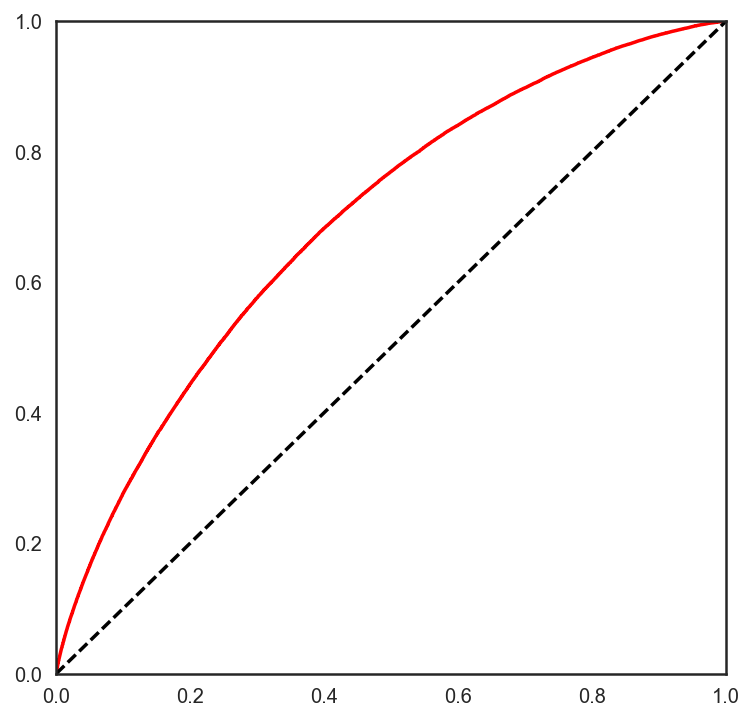

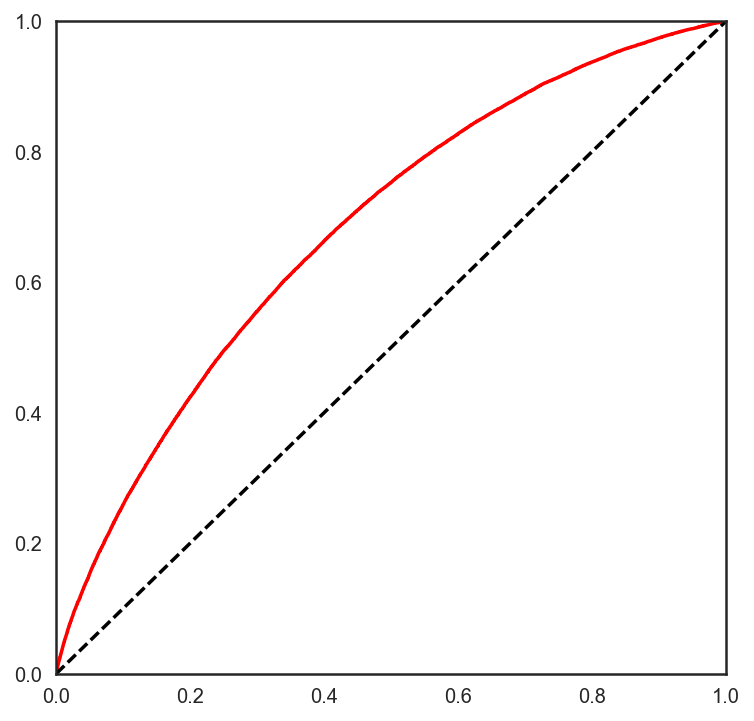

In [71]:
fpr, tpr, th = roc_curve(ally_true, ally_predp)
print(roc_auc_score(ally_true, ally_predp))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

fpr, tpr, th = roc_curve(ally_trueV, ally_predpV)
print(roc_auc_score(ally_trueV, ally_predpV))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))